In [1]:
import utils
from model import VAE

import torch
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import numpy as np

from sklearn.metrics import accuracy_score

from tqdm.notebook import tqdm, trange

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
path = r"./data/"

In [2]:
df = pd.read_csv('block_colors.csv')

# The following is done to force VAE to generate trees
df.loc[0, ['r', 'g']] = [0.0, 0.0]
df.loc[18, ['r', 'g']] = [0.0, 255.0]
df.loc[161, ['r', 'g']] = [0.0, 255.0]
df.loc[17, ['r', 'g']] = [255.0, 0.0]
df.loc[162, ['r', 'g']] = [255.0, 0.0]

In [5]:
pad_shape = 64
limit_shape = 64
filter_values = [0, 18, 17, 161, 162] # These values indicates block ids of trees and logs

samples = utils.get_tensors(path, df, filter_values, pad_shape, limit_shape)

print(f"Samples length: {len(samples)}")

train_dataloader, valid_dataloader = utils.get_loader_binary(samples, batch_size=10)

Samples length: 511


In [6]:
def vae_loss(batch, reconstructed, mu, logvar, kl_weight=1):
    bs = batch.shape[0]

    # Reconstruction loss from the pixels - 1 per image
    reconstruction_loss = F.mse_loss(
        reconstructed.reshape(bs, -1),
        batch.reshape(bs, -1),
        reduction="none",
    ).sum(dim=-1)

    # KL-divergence loss, per input image
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=-1) * kl_weight

    # Combine both losses and get the mean across images
    loss = (reconstruction_loss + kl_loss).mean(dim=0)

    return (loss, reconstruction_loss, kl_loss)

In [7]:
def train_vae(model, num_epochs=10, lr=1e-4, kl_weight=1):
    model = model.to(device)
    losses = {
        "loss": [],
        "reconstruction_loss": [],
        "kl_loss": [],
    }

    model.train()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, eps=1e-5)
    for _ in (progress := trange(num_epochs, desc="Training")):
        for _, batch in (
            inner := tqdm(
                enumerate(train_dataloader), total=len(train_dataloader)
            )
        ):
            batch = batch.to(device)

            # Pass through the model
            reconstructed, mu, logvar = model(batch)

            # Compute the losses
            loss, reconstruction_loss, kl_loss = vae_loss(
                batch, reconstructed, mu, logvar, kl_weight
            )

            # Display loss and store for plotting
            inner.set_postfix(loss=f"{loss.cpu().item():.3f}")
            losses["loss"].append(loss.item())
            losses["reconstruction_loss"].append(
                reconstruction_loss.mean().item()
            )
            losses["kl_loss"].append(kl_loss.mean().item())

            # Update model parameters based on the total loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        progress.set_postfix(loss=f"{loss.cpu().item():.3f}", lr=f"{lr:.0e}")
    return losses

In [8]:
latent_dims = 32
channels = 2

vae_model = VAE(channels, latent_dims)

print(f"Total Params of VAE = {sum(p.numel() for p in vae_model.parameters())}")

Total Params of VAE = 89507714


In [ ]:
# Load weights if provided
state_dict_path = "./checkpoints/checkpoint.pth"
try:
    vae_model.load_state_dict(torch.load(state_dict_path))
except:
    print("Failed to load checkpoint.")

In [ ]:
lr = 1e-3
kl_weight = 1
num_epochs = 3

losses = train_vae(vae_model, num_epochs, lr, kl_weight)

In [ ]:
import shutil
import os

# Example usage
def copy_and_rename(src_path, dest_path, new_name):
    shutil.copy(src_path, dest_path)
    os.rename(dest_path + src_path.split("/")[-1], new_name)

source_file = r"./data/dummy.schematic"
destination_folder = r"./schematics/"

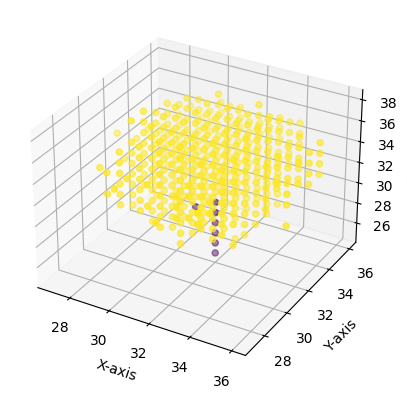

In [ ]:
z = torch.randn((1, latent_dims), device=device)
logs_thresh = 0.15
leaves_thresh = 0.15

vae_model.eval()
with torch.inference_mode():
  v_mesh = vae_model.decode(z)

mesh_result = utils.show_pred(v_mesh, logs_thresh, leaves_thresh)

In [ ]:
sample = samples[0]

vae_model.eval()
with torch.inference_mode():
  reconstruction, *_ = vae_model(sample[None, :].to(device))

utils.show_pred(reconstruction)

In [ ]:
cnt = 4

copy_and_rename(source_file, destination_folder, f"/content/schematics/s{cnt}.schematic")

v_mesh_rec = mesh_result.to(torch.int8)

export = utils.Schematic(*(v_mesh_rec.shape[1:]), v_mesh_rec.reshape(-1).tolist())
path = f"/content/schematics/s{cnt}.schematic"

path = f"/content/schematics/s{cnt}.schematic"

export(path)

In [ ]:
torch.save(vae_model.state_dict(), 'minecraft_tree_generator00.pth')